In [3]:
import cv2
import path
import matplotlib.pyplot as plt
import numpy as np

## Read img file

In [56]:
img_files = path.Path('./data').glob('*')
print(img_files)
imgs = list(map(lambda x:cv2.imread(str(x), cv2.COLOR_RGB2GRAY),img_files))

[Path('./data\\1.jpg'), Path('./data\\2.jpg'), Path('./data\\3.jpg'), Path('./data\\4.jpg'), Path('./data\\5.jpg'), Path('./data\\6.jpg'), Path('./data\\6.png'), Path('./data\\7.jpg')]


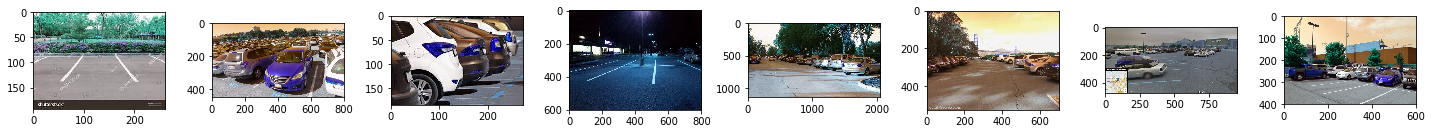

In [57]:
fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
cols = len(img_files)
for idx,img in enumerate(imgs):
    ax = fig.add_subplot(1, cols, idx+1)
    ax.imshow(img)
fig.tight_layout()

In [58]:
def gaussian_blur(img, kernel_size): # 가우시안 필터
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def show_image(img,rows,cols):
    
    fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
    start = 100
    diff = 100

    for i in range(1,rows*cols+1):
        min_thresh = start*i
        max_thresh = min_thresh+diff
        blur_img = gaussian_blur(img, 3) # Blur 효과
        edges = cv2.Canny(blur_img,min_thresh,max_thresh)
        ax = fig.add_subplot(rows, cols, i)
        ax.set_title('min: %d , max: %d'%(min_thresh,max_thresh))
        ax.imshow(edges)
        
    fig.tight_layout() 

## CannyEdge 예시

<Figure size 432x288 with 0 Axes>

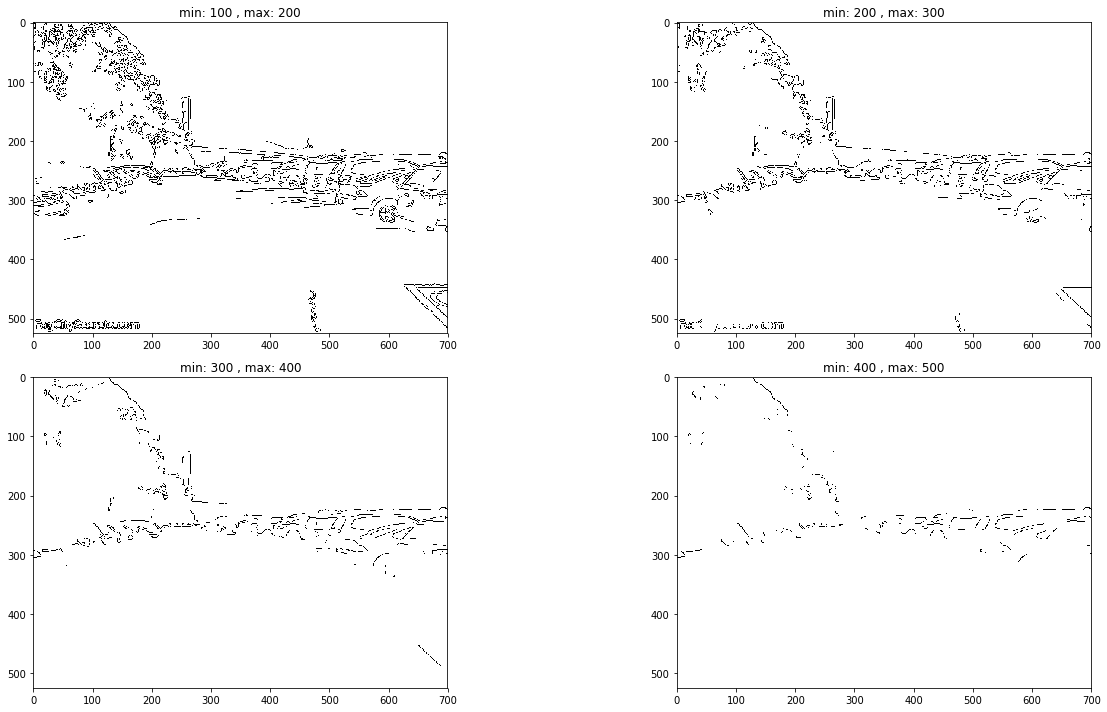

In [59]:
plt.set_cmap('Greys')
show_image(imgs[5],2,2)


## Hough Transform
- [reference](https://m.blog.naver.com/windowsub0406/220894462409)

In [154]:
def draw_lines(img, lines, color=[0, 255, 255], thickness=5): # 선 그리기
    if lines is None: #line이 없는 경우 예외 처리
        return False
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def houghLines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold,np.array([]),minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=1, β=1., λ=0.): # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

def region_of_interest(img, vertices, color3=(255,255,255), color1=255): # ROI 셋팅

    mask = np.zeros_like(img) # mask = img와 같은 크기의 빈 이미지
    
    if len(img.shape) > 2: # Color 이미지(3채널)라면 :
        color = color3
    else: # 흑백 이미지(1채널)라면 :
        color = color1
        
    # vertices에 정한 점들로 이뤄진 다각형부분(ROI 설정부분)을 color로 채움 
    cv2.fillPoly(mask, vertices, color)
    
    # 이미지와 color로 채워진 ROI를 합침
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image

def showLines(imgs,rows,cols):
    
    fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
    for i in range(1,len(imgs)+1):
        
        height, width = imgs[i-1].shape[:2] # 이미지 높이, 너비
        blur_img = gaussian_blur(imgs[i-1], 3) # Blur 효과
        canny_img = cv2.Canny(blur_img,70, 210)
        vertices = np.array([[(50,height),(width/2-45, height/2+60), (width/2+45, height/2+60), (width-50,height)]], dtype=np.int32)
        
        ROI_img = region_of_interest(canny_img, vertices) # ROI 설정
        
        houghResult = houghLines(ROI_img,1, 1 * np.pi/180,30, 10, 20) 
        line_img = np.zeros((imgs[i-1].shape[0], imgs[i-1].shape[1], 3), dtype=np.uint8)
        
        if houghResult is not None:
            draw_lines(line_img, houghResult)
        else:
            print("%d번째 사진은 line detection 안됨"%i)
        result = weighted_img(line_img,imgs[i-1])
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(result)


    fig.tight_layout() 

4번째 사진은 line detection 안됨


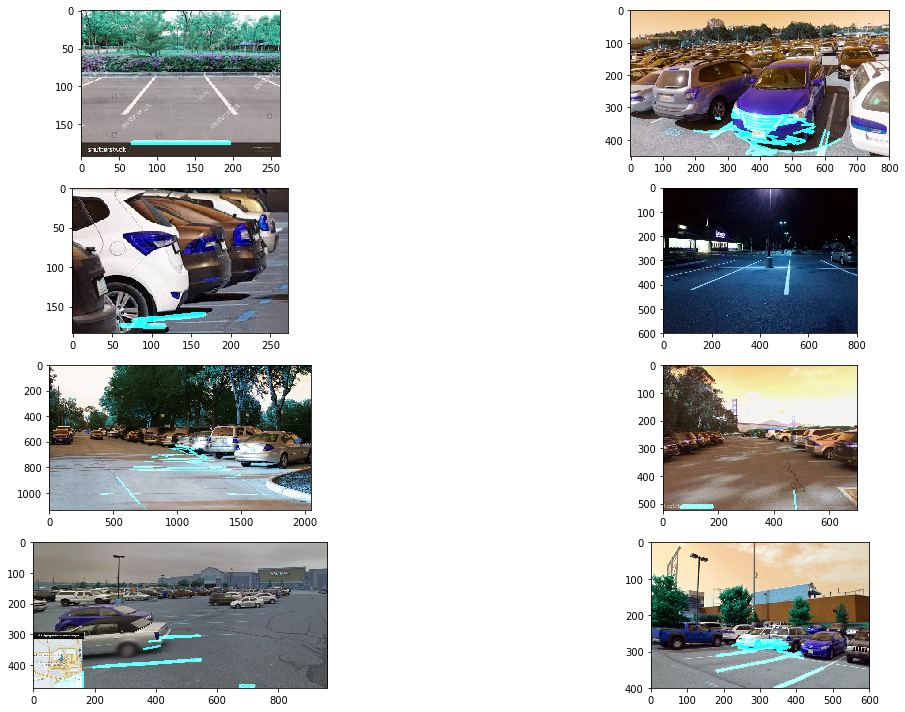

In [153]:
cols = 2
rows = len(imgs)/cols
showLines(imgs,rows,cols)

## ROI 예시

In [97]:
test_img = imgs[3]
height,width,_ = test_img.shape
print('height',height)
print('width',width)
vertices = np.array([[(50,height),(width/2-45, height/2+60), (width/2+45, height/2+60), (width-50,height)]], dtype=np.int32)

height 601
width 800


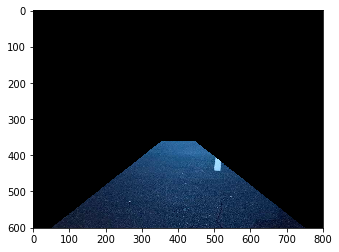

In [98]:
roi = region_of_interest(test_img,vertices)
plt.imshow(roi)

## TODO 

1. ROI 설정